# Some content for playing with Gaussian processes

I have tried to show some of the basic Gaussian process computations, as well as how to use popular packages to conduct them.

In [77]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.linalg import cho_solve, cho_factor, solve_triangular
import matplotlib.pyplot as plt
%matplotlib inline

First, it will help to create a Gaussian process object with some standard functions in it.

We will assume certain properties about our Gaussian process:
* It should have a zero mean
* It should have a Gaussian covariance kernel
* The Gaussian covariance should have individual length scales for each dimension
* There is a fixed Gaussian uncertainty/noise associated with each observation (equivalent to a Tikhonov parameter)
* There is a process variance which 

You can absolutely permit other properties (as discussed in my [textbook](https://www.worldscientific.com/worldscibooks/10.1142/9335)) but we are keeping it simple here for right now because this is enough to show something interesting.

In general, I do not recommend putting this together yourself; I am only doing it here to show what some of the core computations look like.  You are certainly welcome to, but there are other pieces of software that you can use to do this -- and those libraries have been developed and tested by a number of experts.  Of course, if you are doing research on GPs, it may behoove you to have your own code to work with and manipulate.

In [118]:
class GaussianProcess(object):
    def __init__(self, x, y, process_variance, length_scales, observation_noise):
        length_scales = np.array(length_scales)
        x = np.array(x)
        y = np.array(y)
        assert process_variance > 0 and observation_noise >= 0 and all(length_scales > 0)
        assert len(x.shape) == 2 and len(y.shape) == 1 and len(length_scales) == x.shape[1] and x.shape[0] == len(y)
        
        self.x = x
        self.y = y
        self.length_scales = length_scales
        self.process_variance = process_variance
        self.observation_noise = observation_noise
        
        self._distance_matrix_weights = 1 / self.length_scales ** 2
        self._interpolation_weights = None
        self._K_chol = None
        self._initialize()
        
    @property
    def dim(self):
        return self.x.shape[1]
        
    @property
    def num_points(self):
        return self.x.shape[0]
        
    def _initialize(self):
        K = self.compute_covariance(self.x, self.x)
        self._K_chol = cho_factor(K + np.eye(self.num_points) * self.observation_noise, lower=True, overwrite_a=True)
        self._interpolation_weights = cho_solve(self._K_chol, self.y)
    
    def _distance_matrix_squared(self, x, z):
        return cdist(x, z, w=self._distance_matrix_weights, metric='sqeuclidean')
    
    def compute_covariance(self, x, z):
        r_squared = self._distance_matrix_squared(x, z)
        return self.process_variance * np.exp(-r_squared)
    
    def posterior_mean(self, x):
        K_eval = self.compute_covariance(x, self.x)
        return np.dot(K_eval, self._interpolation_weights)
    
    def posterior_variance(self, x):
        K_eval = self.compute_covariance(x, self.x)
        symmetric_term = solve_triangular(self._K_chol[0], K_eval.T, lower=self._K_chol[1], overwrite_b=True)
        schur_complement_term = np.sum(symmetric_term ** 2, axis=0)
        return np.fmax(1e-20, self.process_variance - schur_complement_term)

Choosing Gaussian process parameters (`process_variance`, `length_scales`, `observation_noise`) can be tricky.  This is often done with Maximum Likelihood Estimation, but we will just fix the values right now (rather than try to learn them).

The problem below is an example function called the Franke function.

In [113]:
def yf(x):
    x1, x2 = x.T
    return (
        .75 * np.exp(-.25 * ((9 * x1 - 2) ** 2 + (9 * x2 - 2) ** 2)) +
        .75 * np.exp(-(9 * x1 + 1) ** 2 / 49 - (9 * x2 + 1) / 10) +
        .5 * np.exp(-.25 * ((9 * x1 - 7) ** 2 + (9 * x2 - 3) ** 2)) -
        .2 * np.exp(-(9 * x1 - 4) ** 2 - (9 * x2 - 7) ** 2)
    )

Np = (35, 34)
X0, X1 = np.meshgrid(np.linspace(0, 1, Np[1]), np.linspace(0, 1, Np[0]))
xp = np.array([X0.reshape(-1), X1.reshape(-1)]).T
yp = yf(xp)
Y = yp.reshape(Np)

Now we try to fit a GP to randomly scattered data throughout the domain and see how it looks relative to the true function.

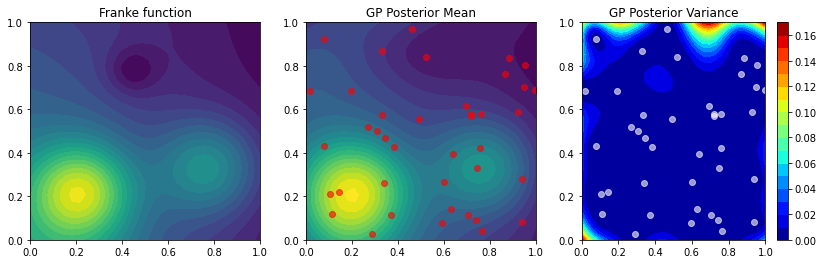

In [126]:
x = np.random.random((40, 2))
y = yf(x)

process_variance = 1.0
length_scales = [.3, .3]
observation_noise = 1e-5
gaussian_process = GaussianProcess(x, y, process_variance, length_scales, observation_noise)

ym = gaussian_process.posterior_mean(xp)
yv = gaussian_process.posterior_variance(xp)
YM = ym.reshape(Np)
YV = yv.reshape(Np)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

ax = axes[0]
ax.contourf(X0, X1, Y, 20)
ax.set_title('Franke function')

ax = axes[1]
ax.contourf(X0, X1, YM, 20, vmin=0.00114, vmax=1.22)
ax.plot(x[:, 0], x[:, 1], 'or', alpha=.6)
ax.set_title('GP Posterior Mean')

ax = axes[2]
h = ax.contourf(X0, X1, YV, 20, cmap='jet')
ax.plot(x[:, 0], x[:, 1], 'ow', alpha=.6)
ax.set_title('GP Posterior Variance')

fig.colorbar(h);

In [31]:
np.all(np.sqrt(cdist(a, b, metric='sqeuclidean')) == cdist(a, b))

True

In [38]:
np.linalg.norm(cdist(a, b, w = [1.0, 2.0]) - cdist(a * np.array([[1, np.sqrt(2)]]), b * np.array([[1, np.sqrt(2)]]))) < 1e-15

True

In [40]:
np.linalg.norm(cdist(a, b, w = [1.0 ** 2, 2.0 ** 2]) - cdist(a * np.array([[1, 2]]), b * np.array([[1, 2]]))) < 1e-15

True